In [1]:
%pip install -e ../

Obtaining file:///home/jovyan/exoplanet_TA_testing
  Preparing metadata (setup.py) ... done
  DEPRECATION: Legacy editable install of exoplanet_lecture_utils==0.0.1 from file:///home/jovyan/exoplanet_TA_testing (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for exoplanet_lecture_utils
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import exoplanet_lecture_utils as elu

/opt/conda/lib/python3.11/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


# EXTRASOLAR PLANETS - Part 1.3
The goal of this project part is to find candidate detections of an exoplanet in the RV-data of a mystery system using Fourier transforms.

## Importing the data

In [2]:
data = pd.read_csv('https://share.phys.ethz.ch/~ipa/exoplanet_lecture_FS24/mystery_system_rv.csv')

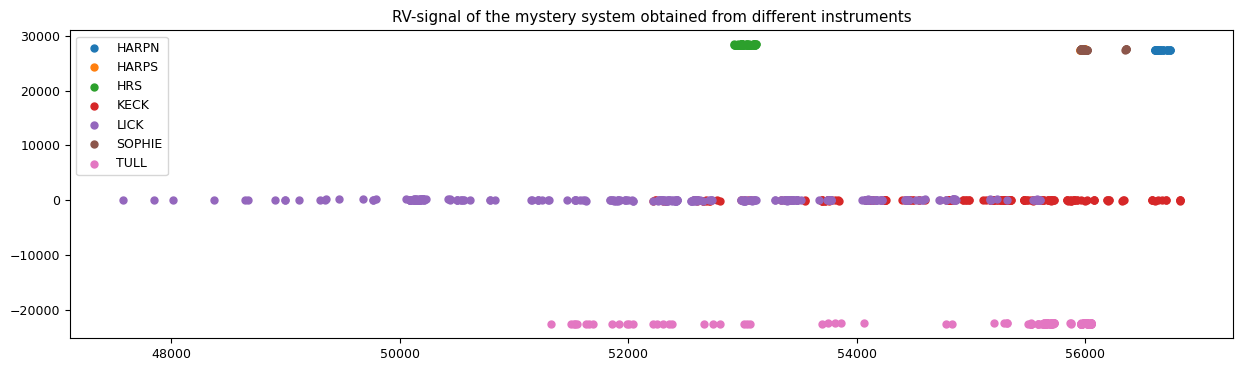

In [3]:
fig, ax = plt.subplots(figsize=(15, 4))

for instrument in data["tel"].unique():
    select_data = data.loc[data["tel"]==instrument]
    ax.scatter(select_data['time'],select_data['mnvel'],label=instrument)

plt.title('RV-signal of the mystery system obtained from different instruments')
plt.legend()
plt.show()

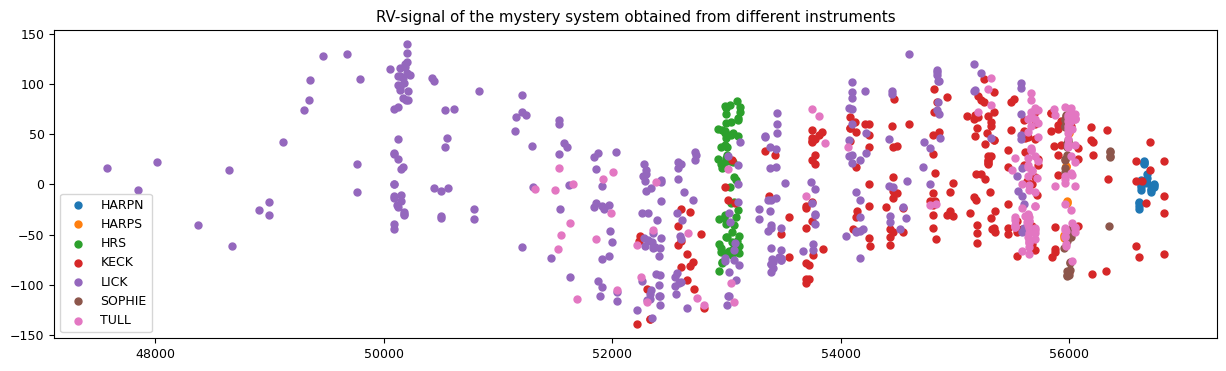

In [4]:
fig, ax = plt.subplots(figsize=(15, 4))

for instrument in data["tel"].unique():
    select_data = data.loc[data["tel"]==instrument]
    data_mean = np.mean(select_data['mnvel'])
    ax.scatter(select_data['time'],select_data['mnvel']-data_mean,label=instrument)

plt.title('RV-signal of the mystery system obtained from different instruments')
plt.legend()
plt.show()

In [5]:
from scipy.signal import lombscargle
from scipy.ndimage import gaussian_filter1d

periods = np.logspace(np.log10(0.1), np.log10(10000), 5000)
w = 2*np.pi/periods

pgram = lombscargle(x=data['time'],
                    y=data['mnvel'],
                    freqs=w)


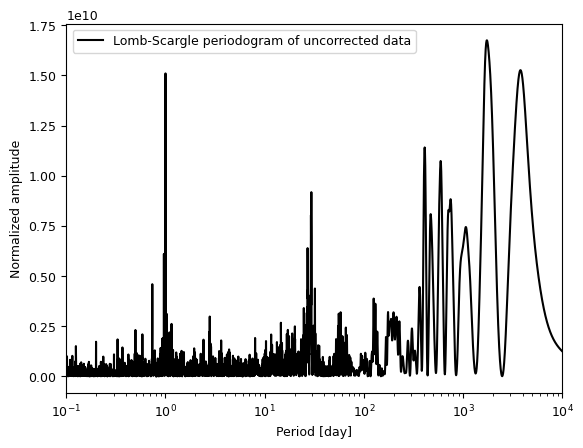

In [6]:
fig, ax = plt.subplots()

ax.plot(periods, pgram, c='k', label='Lomb-Scargle periodogram of uncorrected data')

ax.set_xlabel('Period [day]')
ax.set_ylabel('Normalized amplitude')
ax.set_xlim(np.min(periods)-5, np.max(periods)+5)

plt.legend()

plt.xscale('log')
plt.xlim(0.1, 10000)
plt.show()

In [7]:
# Need to correct for the systematic RV offsets between instruments for the periodogram still!

for inst in np.unique(data['tel']):
    mask = data['tel'] == inst
    data.loc[mask, 'mnvel'] -= np.mean(data['mnvel'][mask])


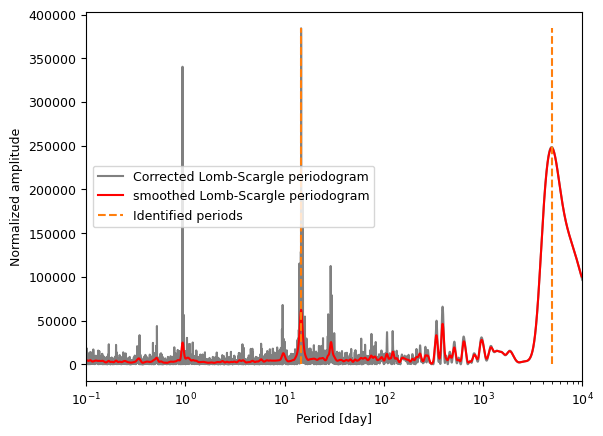

In [8]:
# Now lets repeat with the corrected data, using the gaussian filtering around an appropriate sigma

pgram = lombscargle(x=data['time'],
                    y=data['mnvel'],
                    freqs=w)

fig, ax = plt.subplots()

ax.plot(periods, pgram, c='grey', label='Corrected Lomb-Scargle periodogram')

pgram_smooth = gaussian_filter1d(pgram, 10)
ax.plot(periods, pgram_smooth, c='r', label='smoothed Lomb-Scargle periodogram')

ax.vlines(ymin=0, ymax=np.max(pgram), x=[14.63, 4910], color='tab:orange', ls='--', alpha=1, label='Identified periods')

ax.set_xlabel('Period [day]')
ax.set_ylabel('Normalized amplitude')
ax.set_xlim(np.min(periods)-5, np.max(periods)+5)

plt.legend()

plt.xscale('log')
plt.xlim(0.1, 10000)
plt.show()

# EXTRASOLAR PLANETS - Part 1.4
This demonstrates a fit for longest period planet (4910 days). For the fit to converge it is essential to provide good initial guesses for the parameters.

Try to estimate the period of the planet as precisely as possible from the periodogram (`period`). Also, think about upper and lower limits on the period that you can supply to help the fit converge (`min_period`, `max_period`). From plotting the raw RV data you can also estimate the RV semi-amplitude (`kamp`). In case we have no prior information on the eccentricity, we use the conservative estimate that the eccentricity is less than 0.5 (`emax`).

In [9]:
planet_guess = [{'period': 14.63, 'kamp': 70, 'emax': 0.01, 'min_period': 14.43, 'max_period': 14.83}]

In [10]:
fitter = elu.RadvelWrapper(data=data,
                           guesses=planet_guess)

Initial loglikelihood = -849387.017018
Final loglikelihood = -109654.882436
parameter                     value      vary
per1                        14.6522       True
tc1                           56829       True
secosw1                    0.012194       True
sesinw1                  -0.0992537       True
logk1                       4.24379       True
dvdt                              0      False
curv                              0      False
gamma_HARPN                 51.9385      False
jit_HARPN                  0.955511      False
gamma_HARPS                 13.5673      False
jit_HARPS                  0.955511      False
gamma_HRS                   1.47357      False
jit_HRS                    0.955511      False
gamma_KECK                 -5.11257      False
jit_KECK                   0.955511      False
gamma_LICK                 0.665633      False
jit_LICK                   0.955511      False
gamma_SOPHIE               -15.3946      False
jit_SOPHIE                 0.955

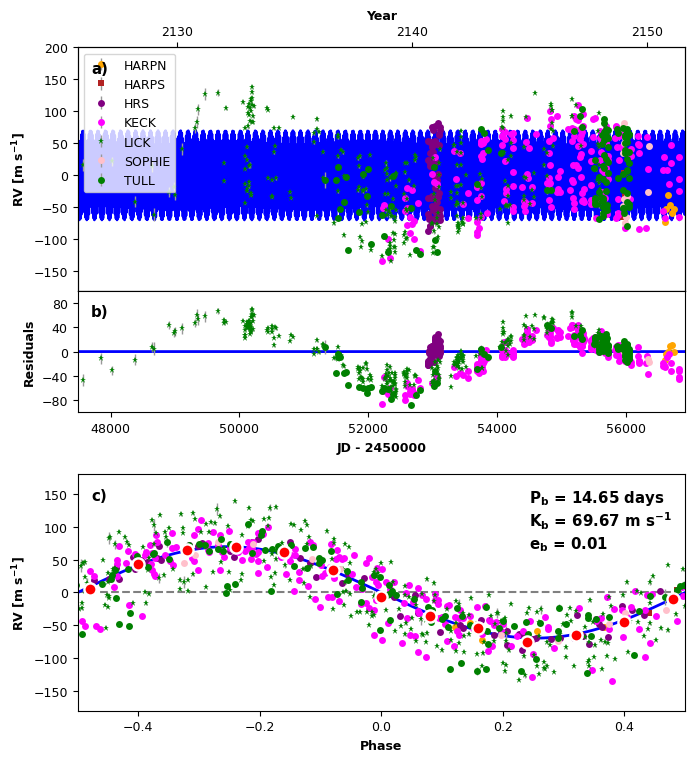

In [11]:
fitter.max_likelihood_fit()
fitter.plot_rv_fit()
results_b = fitter.get_posterior()

In [12]:
planet_guess = [{'period': 4910, 'kamp': 50, 'emax': 0.5, 'min_period': None, 'max_period': None}]

fitter = elu.RadvelWrapper(data=data,
                           guesses=planet_guess)

Initial loglikelihood = -400426.397790
Final loglikelihood = -345152.536440
parameter                     value      vary
per1                        5332.98       True
tc1                         56913.9       True
secosw1                   -0.467872       True
sesinw1                    0.122566       True
logk1                       3.83042       True
dvdt                              0      False
curv                              0      False
gamma_HARPN                -4.11116      False
jit_HARPN                  0.955511      False
gamma_HARPS                 -29.462      False
jit_HARPS                  0.955511      False
gamma_HRS                   34.2406      False
jit_HRS                    0.955511      False
gamma_KECK                 -15.9198      False
jit_KECK                   0.955511      False
gamma_LICK                 0.576709      False
jit_LICK                   0.955511      False
gamma_SOPHIE               -33.9346      False
jit_SOPHIE                 0.955

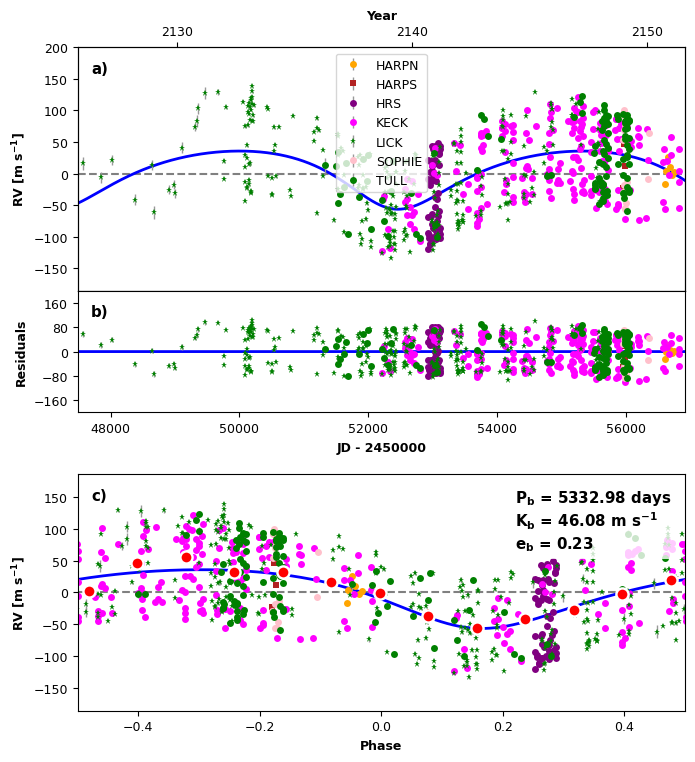

In [13]:
fitter.max_likelihood_fit()
fitter.plot_rv_fit()
results_c = fitter.get_posterior()

In [53]:
print(results_c)

[{'kamp': 46.0819810801299, 'period': 5332.9837695534725, 'e': 0.23392619735034337}]


In [14]:
planet_guesses = [{'period': 14.63, 'kamp': 70, 'emax': 0.01, 'min_period': 14.43, 'max_period': 14.83},
                  {'period': 4910, 'kamp': 50, 'emax': 0.5, 'min_period': None, 'max_period': None}]

Now we initialize the fitting algorithm (based on the `radvel` package) with the initial guesses and the data.

In [15]:
fitter = elu.RadvelWrapper(data=data,
                           guesses=planet_guesses)

We can now fit the model to the data, plot the results and save them in the `results` array.

Initial loglikelihood = -813786.730617
Final loglikelihood = -15828.434720
parameter                     value      vary
per1                        14.6521       True
tc1                           56829       True
secosw1                 -0.00194338       True
sesinw1                   0.0999811       True
logk1                       4.25892       True
per2                         5110.7       True
tc2                         56289.2       True
secosw2                   0.0495581       True
sesinw2                    -0.24377       True
logk2                       3.78501       True
dvdt                              0      False
curv                              0      False
gamma_HARPN                 70.3791      False
jit_HARPN                  0.955511      False
gamma_HARPS                -2.99091      False
jit_HARPS                  0.955511      False
gamma_HRS                    38.603      False
jit_HRS                    0.955511      False
gamma_KECK                 -23.26

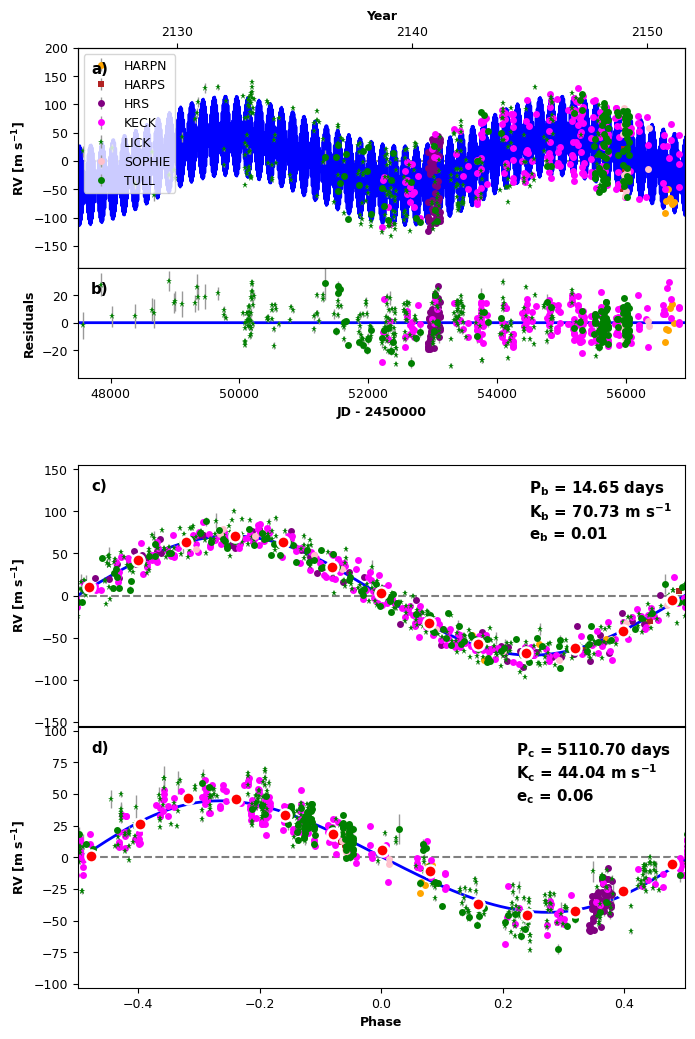

In [16]:
fitter.max_likelihood_fit()
fitter.plot_rv_fit()
results_b_c = fitter.get_posterior()

Here are the results of the fit. Note that `kamp` is given in m/s and `period` in days.

In [17]:
print(results_b_c)

[{'kamp': 70.73358450884983, 'period': 14.652094339116463, 'e': 0.009999999999989882}, {'kamp': 44.03591314734787, 'period': 5110.695773944306, 'e': 0.06187966609559916}]


In [18]:
def get_msini(period, kamp, ecc, star_mass):
    """
    Calculate the minimum mass of a planet based on the radial velocity amplitude, the period, and the eccentricity.

    Parameters:
    period (float): The period of the planet's orbit in seconds.
    kamp (float): The amplitude of the radial velocity signal in m/s.
    ecc (float): The eccentricity of the planet's orbit.
    star_mass (float): The mass of the star in kg.

    Returns:
    float: The minimum mass of the planet in Jupiter masses.
    """
    return (period / (2*np.pi*6.67e-11))**(1/3) * kamp * np.sqrt(1 - ecc**2) * star_mass**(2/3)

In [19]:
min_masses = [get_msini(period=r['period']*24*60*60, kamp=r['kamp'], ecc=r['e'], star_mass=1.9293e30) / 1.899e27 for r in results_b_c]
print('Assuming Solar mass star:')
for i in range(len(min_masses)):
    print(f'Minimum mass of planet {i+1}: {min_masses[i]:.2f} Jupiter masses')

Assuming Solar mass star:
Minimum mass of planet 1: 0.83 Jupiter masses
Minimum mass of planet 2: 3.65 Jupiter masses


In [20]:
# search exoplanet archive
pnasa = elu.get_exoplanet_data()
list(pnasa)

['Unnamed: 0',
 'pl_name',
 'hostname',
 'pl_letter',
 'discoverymethod',
 'pl_orbsmax',
 'pl_bmassj',
 'pl_orbper',
 'pl_rvamp',
 'pl_orbeccen']

In [21]:
for host in pnasa['hostname'].unique():
    select_pnasa = pnasa.loc[pnasa['hostname']==host]
    select_periods = select_pnasa.pl_orbper.to_numpy()
    select_Kamps = select_pnasa.pl_rvamp.to_numpy()
    if len(select_periods)>=2:
        for i in range(len(select_periods)):
            if select_periods[i] > 10 and select_periods[i] < 20 and select_Kamps[i] > 65 and select_Kamps[i] < 75:
                print(host)

55 Cnc


In [22]:
print(pnasa.loc[pnasa['hostname']=='55 Cnc'])

    Unnamed: 0   pl_name hostname pl_letter  discoverymethod  pl_orbsmax  \
27          27  55 Cnc b   55 Cnc         b  Radial Velocity     0.11340   
28          28  55 Cnc c   55 Cnc         c  Radial Velocity     0.23730   
29          29  55 Cnc d   55 Cnc         d  Radial Velocity     5.95700   
30          30  55 Cnc e   55 Cnc         e  Radial Velocity     0.01544   
31          31  55 Cnc f   55 Cnc         f  Radial Velocity     0.77080   

    pl_bmassj    pl_orbper  pl_rvamp  pl_orbeccen  
27    0.83060    14.651600     71.37         0.00  
28    0.17140    44.398900      9.89         0.03  
29    3.87800  5574.200000     38.60         0.13  
30    0.02514     0.736547      6.02         0.05  
31    0.14100   259.880000      5.14         0.08  


## A tip for advanced analyses
To identify planets with smaller RV amplitudes, it can be very useful to subtract the fits of already identified planets from the data. Then the periodogram of this 'cleaned' data can be used to identify additional planets. This process can be repeated iteratively to identify multiple planets in the same system.

In [23]:
data_subtracted = fitter.subtract_fit_from_data()

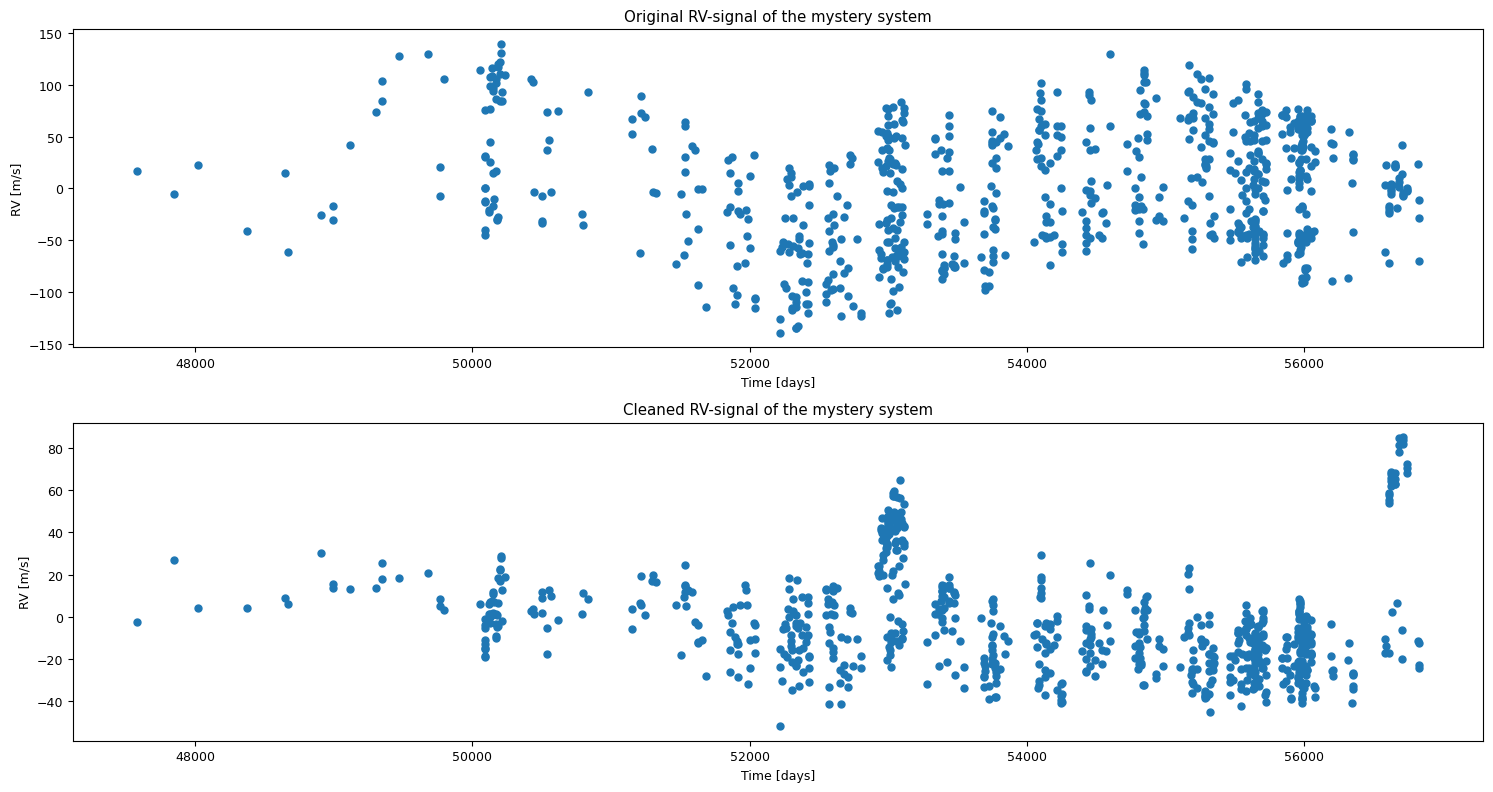

In [24]:
fig, ax = plt.subplots(figsize=(15, 8), nrows=2)
#ax[0].scatter(data['time'][data['tel'] == 'LICK'], data['mnvel'][data['tel'] == 'LICK'])
ax[0].scatter(data['time'], data['mnvel'])
ax[0].set_title('Original RV-signal of the mystery system')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('RV [m/s]')

#ax[1].scatter(data_subtracted['time'][data_subtracted['tel'] == 'LICK'], data_subtracted['mnvel'][data_subtracted['tel'] == 'LICK'])
ax[1].scatter(data_subtracted['time'], data_subtracted['mnvel'])
ax[1].set_title('Cleaned RV-signal of the mystery system')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('RV [m/s]')

plt.tight_layout()
plt.show()

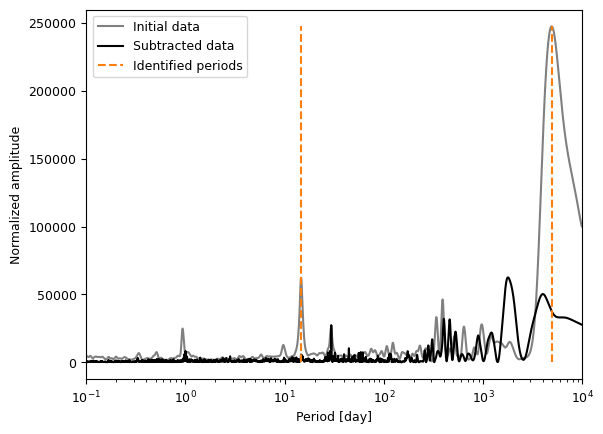

In [25]:
fig, ax = plt.subplots()

pgram = lombscargle(x=data['time'],
                    y=data['mnvel'],
                    freqs=w)

pgram_init = gaussian_filter1d(pgram, 10)

ax.plot(periods, pgram_init, c='grey', label='Initial data')

pgram = lombscargle(x=data_subtracted['time'],
                    y=data_subtracted['mnvel'],
                    freqs=w)

pgram_smooth = gaussian_filter1d(pgram, 1)

ax.plot(periods, pgram_smooth, c='k', label='Subtracted data')

ax.vlines(ymin=0, ymax=np.max(pgram_init), x=[14.63, 4910], color='tab:orange', ls='--', alpha=1, label='Identified periods')
ax.set_xlabel('Period [day]')
ax.set_ylabel('Normalized amplitude')
ax.set_xlim(np.min(periods)-5, np.max(periods)+5)

plt.legend()

plt.xscale('log')
plt.xlim(0.1, 10000)
plt.show()

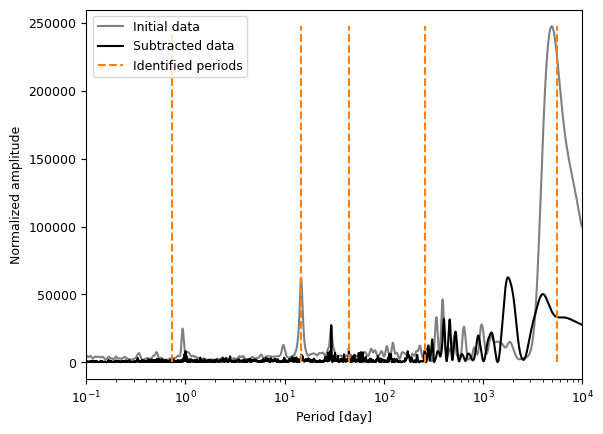

In [26]:
fig, ax = plt.subplots()

pgram = lombscargle(x=data['time'],
                    y=data['mnvel'],
                    freqs=w)

pgram_init = gaussian_filter1d(pgram, 10)

ax.plot(periods, pgram_init, c='grey', label='Initial data')

pgram = lombscargle(x=data_subtracted['time'],
                    y=data_subtracted['mnvel'],
                    freqs=w)

pgram_smooth = gaussian_filter1d(pgram, 1)

ax.plot(periods, pgram_smooth, c='k', label='Subtracted data')

ax.vlines(ymin=0, ymax=np.max(pgram_init), x=[14.651600, 44.398900, 5574.200000, 0.736547, 259.880000], color='tab:orange', ls='--', alpha=1, label='Identified periods')
ax.set_xlabel('Period [day]')
ax.set_ylabel('Normalized amplitude')
ax.set_xlim(np.min(periods)-5, np.max(periods)+5)

plt.legend()

plt.xscale('log')
plt.xlim(0.1, 10000)
plt.show()

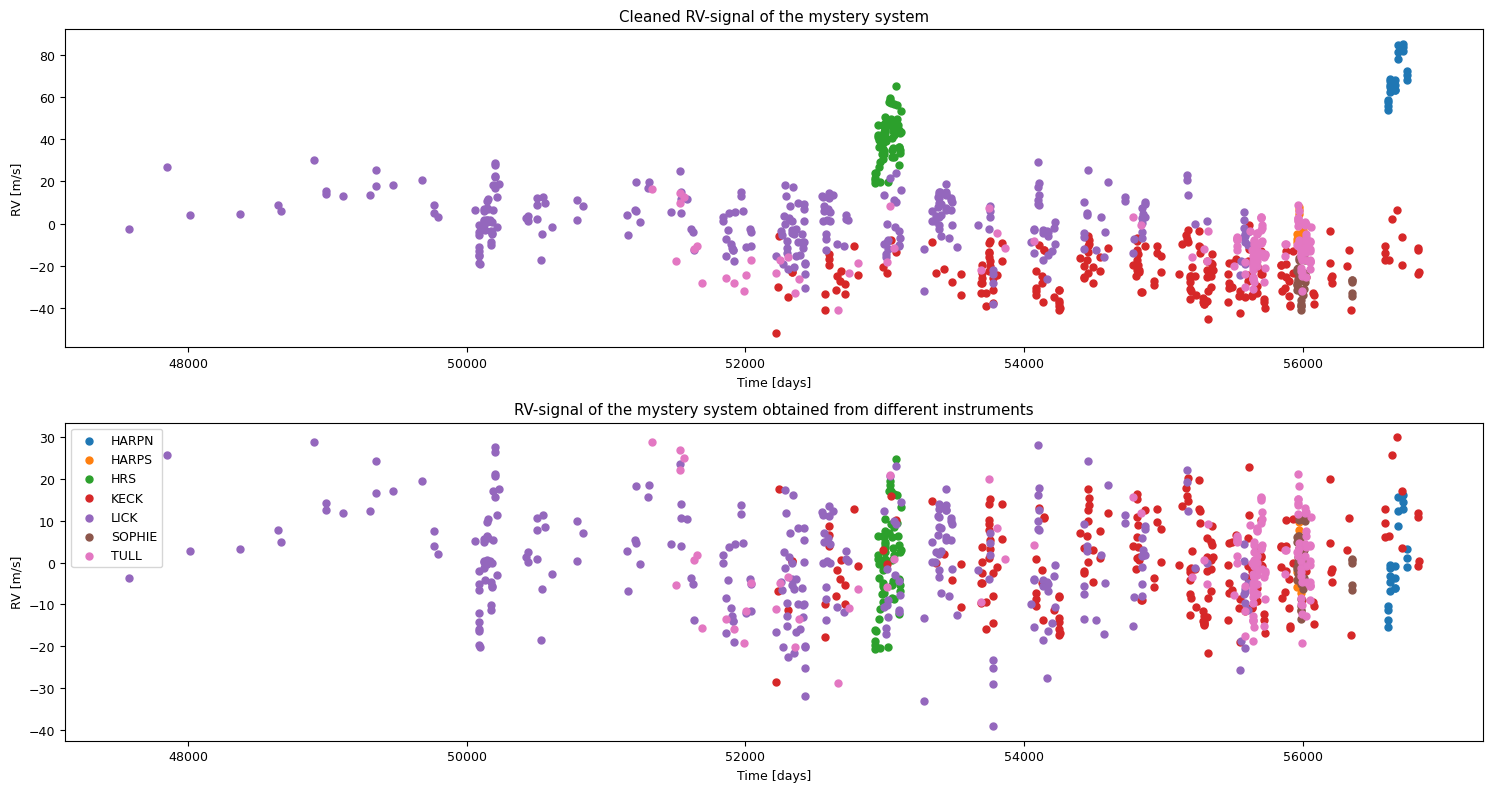

In [27]:
fig, ax = plt.subplots(figsize=(15, 8), nrows=2)


for instrument in data_subtracted["tel"].unique():
    select_data = data_subtracted.loc[data_subtracted["tel"]==instrument]
    ax[0].scatter(select_data['time'],select_data['mnvel'],label=instrument)
    
ax[0].set_title('Cleaned RV-signal of the mystery system')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('RV [m/s]')


for instrument in data_subtracted["tel"].unique():
    select_data = data_subtracted.loc[data_subtracted["tel"]==instrument]
    data_mean = np.mean(select_data['mnvel'])
    ax[1].scatter(select_data['time'],select_data['mnvel']-data_mean,label=instrument)
    
ax[1].set_title('Cleaned RV-signal of the mystery system')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('RV [m/s]')

plt.tight_layout()

plt.title('RV-signal of the mystery system obtained from different instruments')
plt.legend()
plt.show()

In [28]:
for inst in np.unique(data_subtracted['tel']):
    mask = data_subtracted['tel'] == inst
    data_subtracted.loc[mask, 'mnvel'] -= np.mean(data_subtracted['mnvel'][mask])


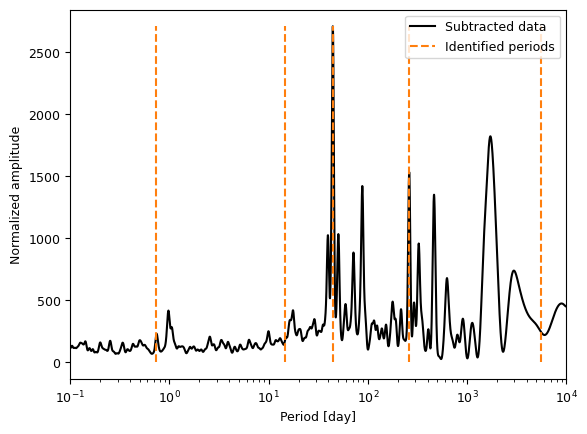

In [29]:
fig, ax = plt.subplots()

pgram = lombscargle(x=data_subtracted['time'],
                    y=data_subtracted['mnvel'],
                    freqs=w)

pgram_smooth = gaussian_filter1d(pgram, 10)

ax.plot(periods, pgram_smooth, c='k', label='Subtracted data')

ax.vlines(ymin=0, ymax=np.max(pgram_smooth), x=[14.651600, 44.398900, 5574.200000, 0.736547, 259.880000], color='tab:orange', ls='--', alpha=1, label='Identified periods')
ax.set_xlabel('Period [day]')
ax.set_ylabel('Normalized amplitude')
ax.set_xlim(np.min(periods)-5, np.max(periods)+5)

plt.legend()

plt.xscale('log')
plt.xlim(0.1, 10000)
plt.show()

In [100]:
planet_guesses = [
    {'period': 14.63,  # in days
     'kamp': 70,  # in m/s
     'emax': 0.01,
     'min_period': 14.43,  # in days
     'max_period': 14.83}  # in days
]

In [101]:
fitter = elu.RadvelWrapper(data=data_subtracted,
                           guesses=planet_guess_2)

Initial loglikelihood = -761578.809495
Final loglikelihood = -23183.896116
parameter                     value      vary
per1                        14.6522       True
tc1                         56829.1       True
secosw1                  -0.0672904       True
sesinw1                    0.073973       True
logk1                       4.23732       True
dvdt                              0      False
curv                              0      False
gamma_HARPN                 48.9842      False
jit_HARPN                  0.955511      False
gamma_HARPS                -16.5632      False
jit_HARPS                  0.955511      False
gamma_HRS                   38.5664      False
jit_HRS                    0.955511      False
gamma_KECK                 -23.8452      False
jit_KECK                   0.955511      False
gamma_LICK                   3.4121      False
jit_LICK                   0.955511      False
gamma_SOPHIE                -42.768      False
jit_SOPHIE                 0.9555

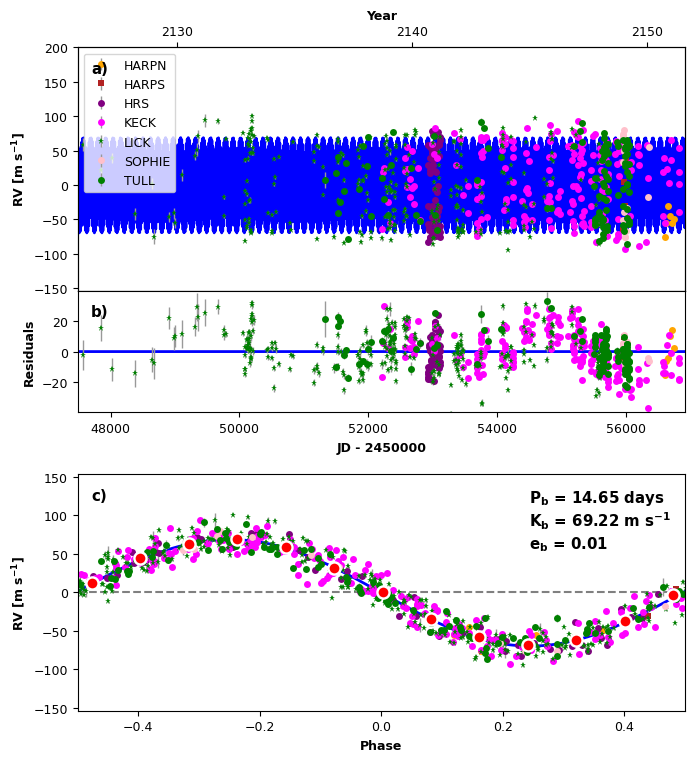

In [102]:
fitter.max_likelihood_fit()
fitter.plot_rv_fit()
results = fitter.get_posterior()

In [103]:
print(results)

[{'kamp': 69.22217718609245, 'period': 14.652199422359422, 'e': 0.009999999999132989}]


In [104]:
data_subtracted_2 = fitter.subtract_fit_from_data()